<a href="https://colab.research.google.com/github/yoshih8/recipes/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install --ignore-installed Pillow==9.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.3.0-cp38-cp38-manylinux_2_28_x86_64.whl (3.3 MB)


In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from datasets import load_dataset

import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from diffusers import DDPMScheduler
from diffusers import DDPMPipeline


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255  # permute is change the order (0, 1, 2) -- (1, 2, 0) clip is change value between min=0 and max=1 
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)


## References 
# https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb 
# https://github.com/huggingface/diffusion-models-class/tree/main/unit1#what-are-diffusion-models




cuda


Prepare dataset

Resolving data files:   0%|          | 0/60 [00:00<?, ?it/s]

X shape: torch.Size([8, 3, 32, 32])


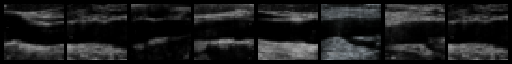

In [ ]:
#dataset = load_dataset("content/drive/MyDrive/Images_test", split="train")

# Or load images from a local folder
dataset = load_dataset("/content/drive/MyDrive/Images_test", split='train')

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 16

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)


xb = next(iter(train_dataloader))["images"].to(device)[:8]

print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.Resampling(0))

#https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Resampling.NEAREST
#BICUBIC = 3; BILINEAR = 2; BOX = 4; HAMMING = 5; LANCZOS = 1; NEAREST = 0

Prepare the diffusers

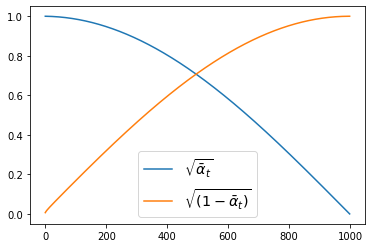

In [ ]:
# from diffusers import DDPMPipeline

### Default linear scheduler 
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

### One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=200, beta_start=0.01, beta_end=0.001)
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)

#### The 'cosine' schedule, which may be better for small image sizes:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Noisy X shape torch.Size([8, 3, 32, 32])


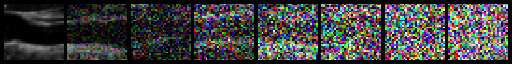

In [ ]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)  
#Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.Resampling(0))

Define the Model

In [ ]:
from diffusers import UNet2DModel
IMAGE_SIZE=32
IN_CHANNELS=3

# Create a model
model = UNet2DModel(
    sample_size=IMAGE_SIZE,  # the target image resolution
    in_channels=IN_CHANNELS,  # the number of input channels, 3 for RGB images
    out_channels=IN_CHANNELS,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

In [ ]:
## Sanity check for model_prediciton shape
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

Training Loops

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []
# epoch_number = 30 from the example
epoch_number = 5

for epoch in range(epoch_number):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:5, loss: 0.13242614082992077


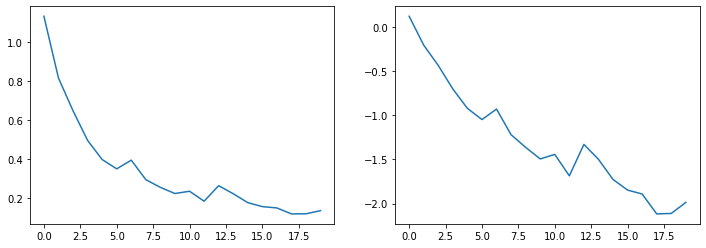

In [ ]:
## plot raw losses  and log(losses)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

Creating images

Option 1: Creating a pipeline

In [ ]:
image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [ ]:
pipeline_output = image_pipe()

  0%|          | 0/1000 [00:00<?, ?it/s]

(32, 32)


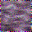

In [ ]:
print(pipeline_output.images[0].size)
pipeline_output.images[0]

In [ ]:
image_pipe.save_pretrained("my_pipeline")

In [ ]:
ls -la my_pipeline/

total 20
drwxr-xr-x 4 root root 4096 Jan 27 10:27 ./
drwxr-xr-x 1 root root 4096 Jan 27 10:27 ../
-rw-r--r-- 1 root root  181 Jan 27 10:27 model_index.json
drwxr-xr-x 2 root root 4096 Jan 27 10:27 scheduler/
drwxr-xr-x 2 root root 4096 Jan 27 10:27 unet/


Option 2: Writing a Sampling Loop

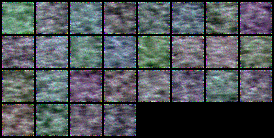

In [ ]:
# Random starting point (number_of_samples random images):
number_of_samples = 28
sample = torch.randn(number_of_samples, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

Next Steps
1 Create google collab notebook of the above notebook using the following commands to install packages
!pip install -q -U ADD_PACKAGES 
#%pip install -qq -U ADD_PACKAGES Alternatively! 
2 Test workflow with different

image resolutions: 8x8, 16x16;
epoch_number: 5, 10, 15.
Test different num_train_timesteps and beta_schedule in DDPMScheduler
DDPMScheduler(num_train_timesteps=????, beta_schedule=linear, scaled_linear, or squaredcos_cap_v2.
Make conclusions on the loss curve
References:

01_introduction_to_diffusers.ipynb
annotated_diffusion.ipynb